In [20]:
import os
import numpy as np
from PIL import Image


def load_images(image_folder, image_size=(128, 128)):
    images = []
    for filename in os.listdir(image_folder):
        img = Image.open(os.path.join(image_folder, filename)).convert('L')
        img = img.resize(image_size)
        img = np.array(img)
        img = (img - 127.5) / 127.5
        images.append(img)
    return np.expand_dims(np.array(images), axis=-1)


images = load_images(os.path.join(os.getcwd(), "train/sea"))

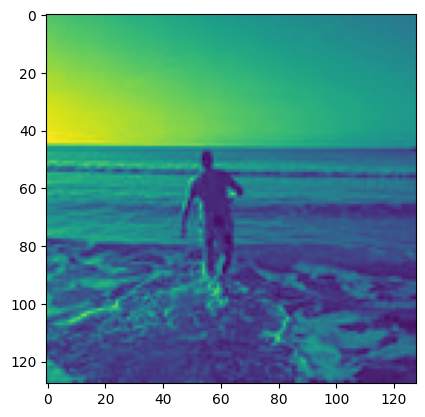

In [21]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

plt.imshow(images[1])
plt.show()